
📊 Resumen estadístico para Spain_meteo_dirty_2018_2022:

                GHI           DNI           DHI         TempC      Wind_mps
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000
mean     277.343706    306.782419     24.623831     14.666554      4.843824
std     1401.238105   1519.509240     36.777443     11.226376      6.664521
min        0.000000      0.000000      0.000000    -35.000000      0.000000
25%        0.000000      0.000000      0.000000      7.736152      2.946344
50%       11.229056     16.136922      9.047712     14.659799      4.004772
75%       62.962023     88.532223     33.648871     21.572111      5.072055
max    11000.000000  12000.000000    228.755767     65.000000     55.000000

📊 Resumen estadístico para Chile_meteo_dirty_2018_2022:

                GHI           DNI           DHI         TempC      Wind_mps
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000
mean     283.796078    311.417817     25.865507 

/tmp/ipykernel_3101/2203129526.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(df['Timestamp'].min(),
/tmp/ipykernel_3101/2203129526.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(df['Timestamp'].min(),



📊 Resumen estadístico para Australia_meteo_dirty_2018_2022:

                GHI           DNI           DHI         TempC      Wind_mps
count  43824.000000  43824.000000  43824.000000  43824.000000  43824.000000
mean     286.950351    317.863617     26.388775     14.736966      4.839270
std     1401.889768   1518.402795     40.897447     11.243769      6.673066
min        0.000000      0.000000      0.000000    -35.000000      0.000000
25%        0.000000      0.000000      0.000000      7.808030      2.939175
50%       11.460748     16.149957      8.945844     14.762436      3.995992
75%       64.021665     92.317553     33.954056     21.706817      5.054582
max    11000.000000  12000.000000    254.112341     65.000000     55.000000

📈 Series limpias para Spain_meteo_dirty_2018_2022


/tmp/ipykernel_3101/2203129526.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(df['Timestamp'].min(),


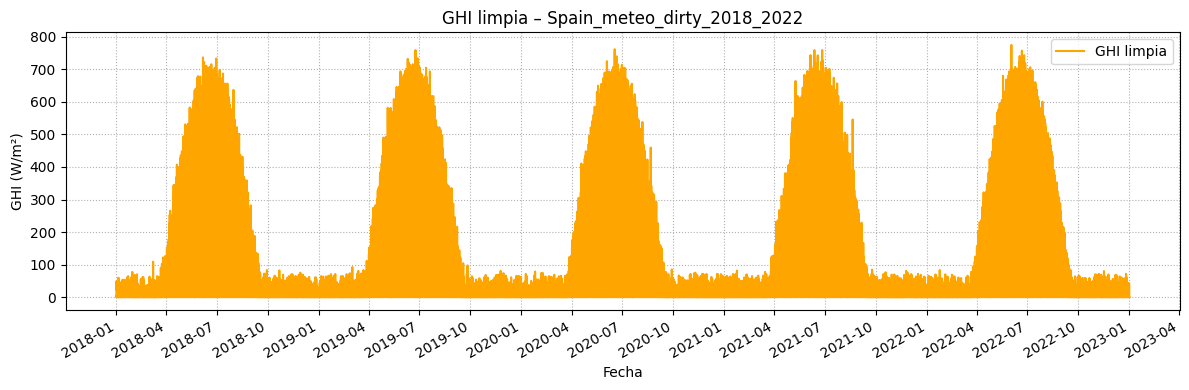

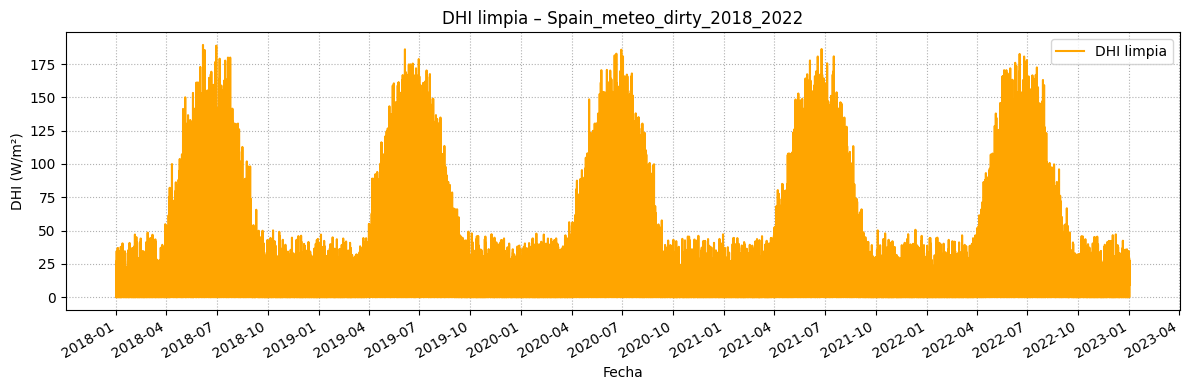

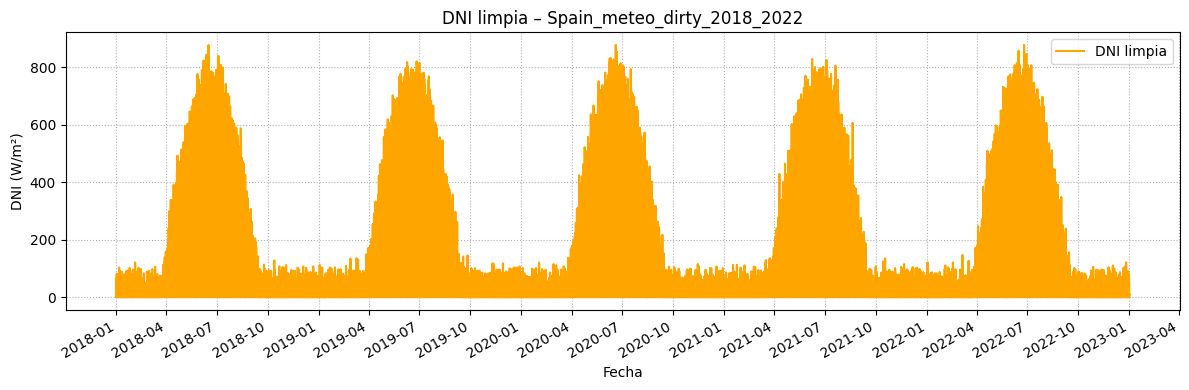

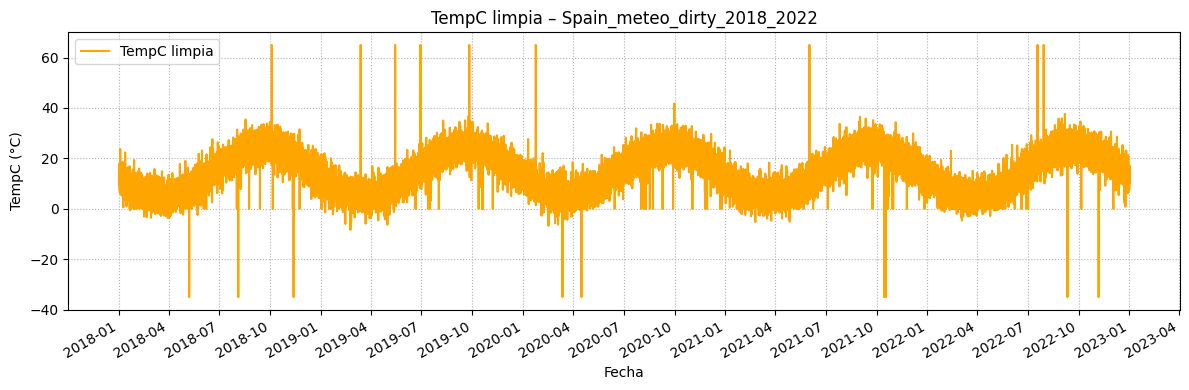

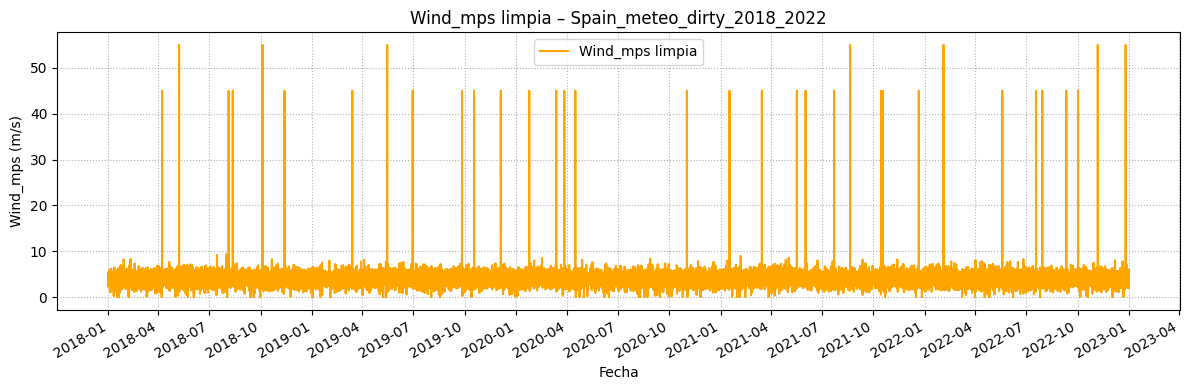


📈 Series limpias para Chile_meteo_dirty_2018_2022


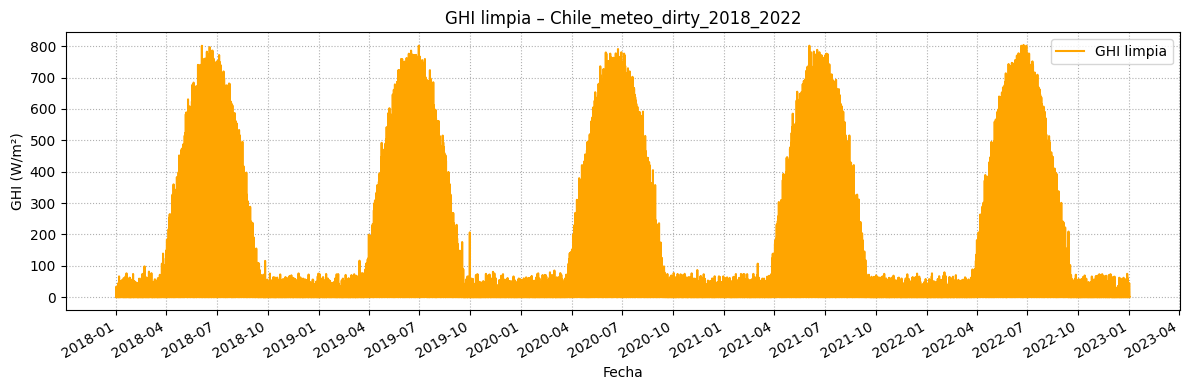

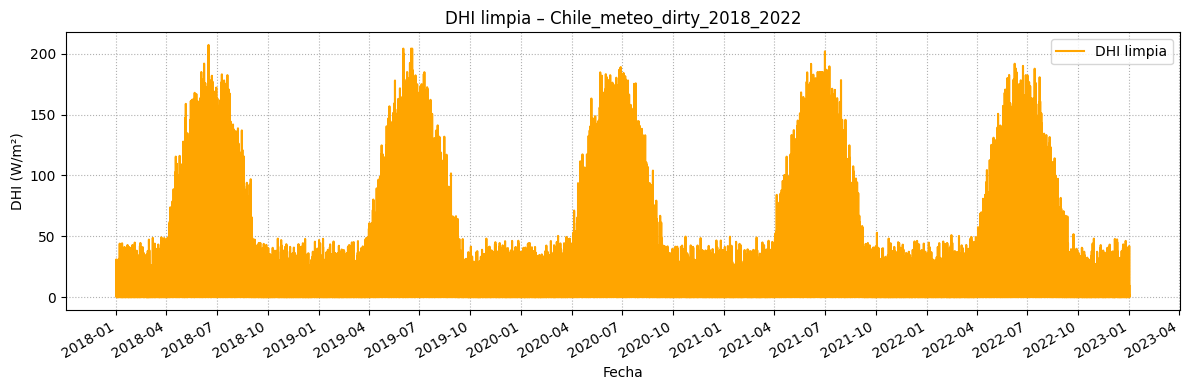

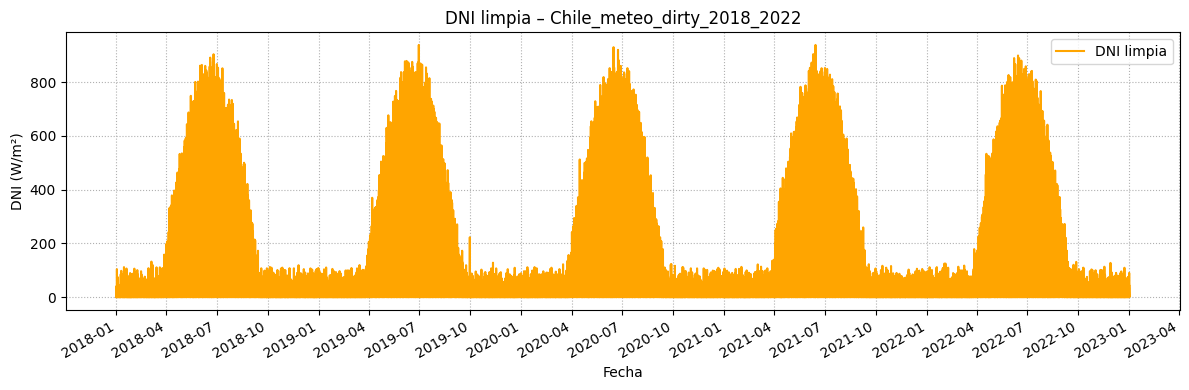

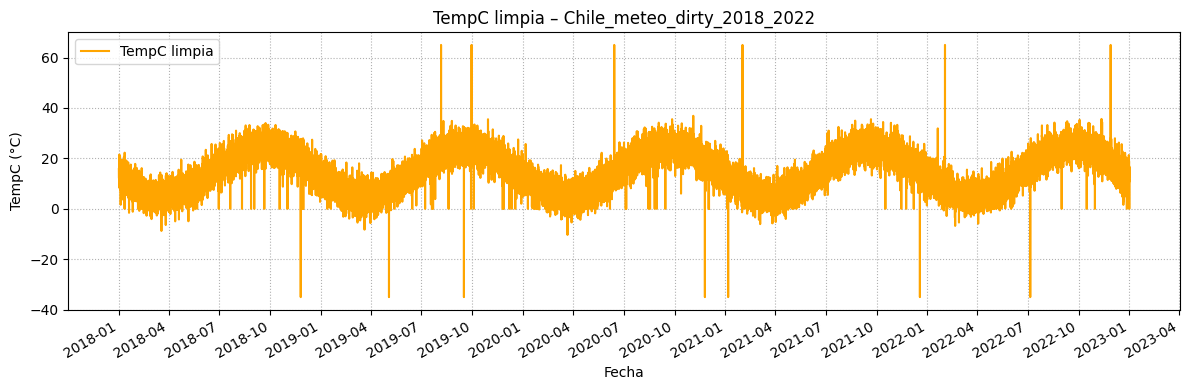

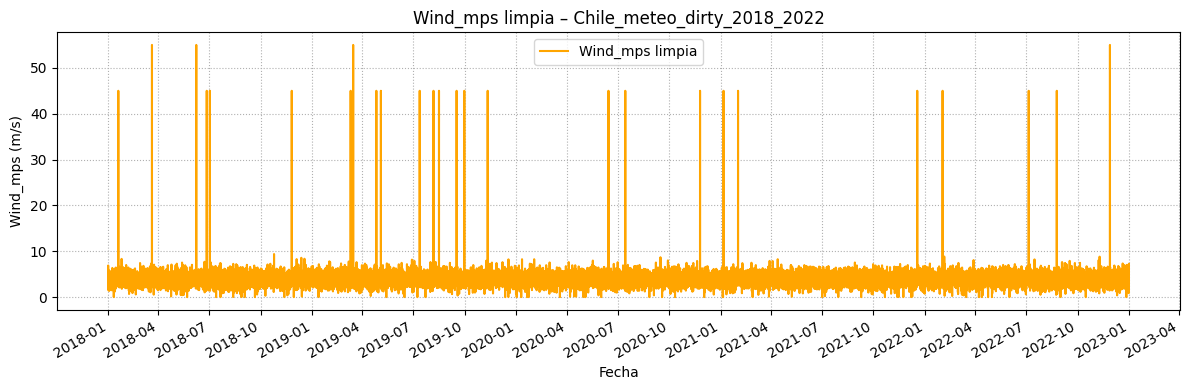


📈 Series limpias para Australia_meteo_dirty_2018_2022


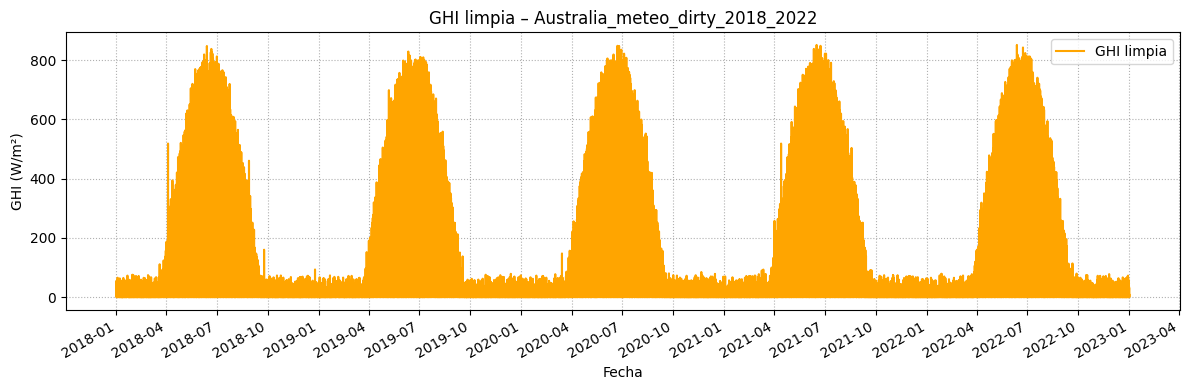

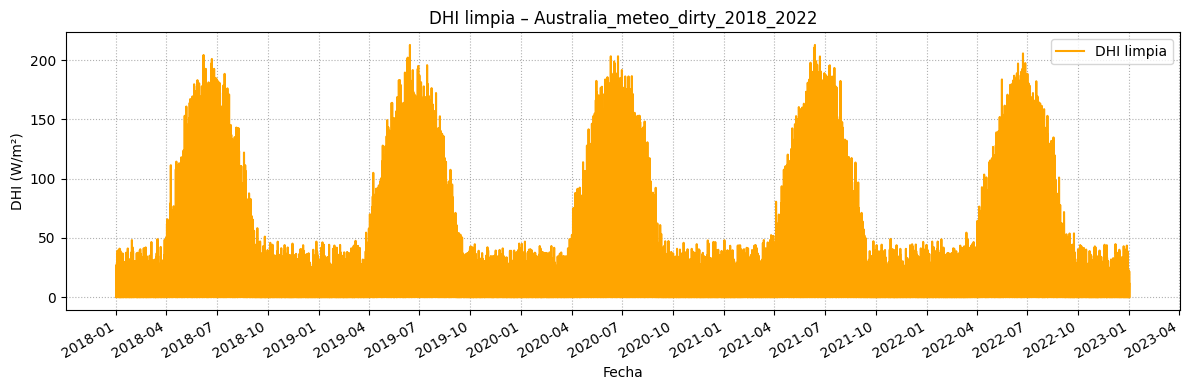

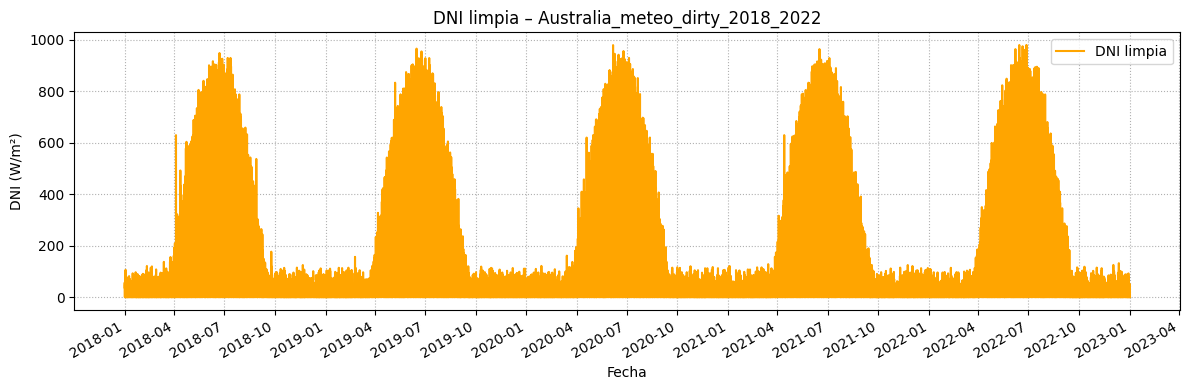

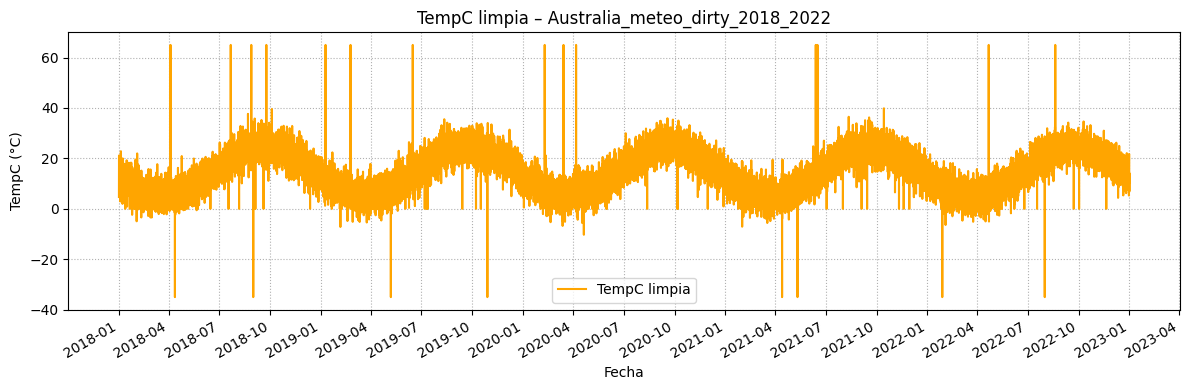

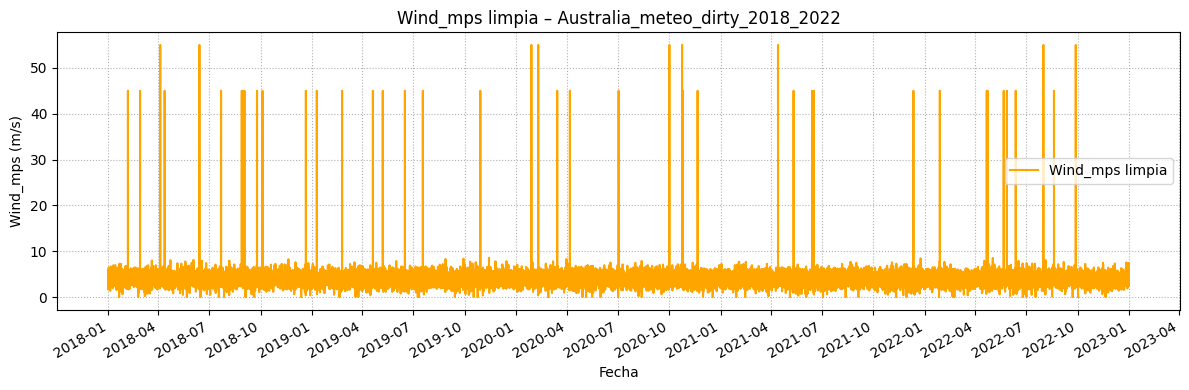

✅ Guardado: /home/miguelo/molivares/PRUEBA 2/Spain_meteo_dirty_2018_2022_filtrado.csv
✅ Guardado: /home/miguelo/molivares/PRUEBA 2/Chile_meteo_dirty_2018_2022_filtrado.csv
✅ Guardado: /home/miguelo/molivares/PRUEBA 2/Australia_meteo_dirty_2018_2022_filtrado.csv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# ------------------------------------------------------------------
# 0) Definir carpeta y archivos
# ------------------------------------------------------------------
base_path = "/home/miguelo/molivares/PRUEBA 2"
file_names = [
    "Spain_meteo_dirty_2018_2022.csv",
    "Chile_meteo_dirty_2018_2022.csv",
    "Australia_meteo_dirty_2018_2022.csv"
]

# ------------------------------------------------------------------
# 1) Función para cargar y limpiar CSV con columna Timestamp
# ------------------------------------------------------------------
def cargar_y_limpiar_csv_dirty(filepath, country):
    df = pd.read_csv(filepath, parse_dates=['Timestamp'])
    df.columns = df.columns.str.strip()
    
    # Limpiar strings vacíos o 'NA'
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = (
                df[col].astype(str)
                       .str.strip()
                       .replace({'': np.nan, 'NA': np.nan, 'NaN': np.nan})
            )
    # Convertir a numérico (salvo Timestamp)
    for col in df.columns:
        if col != 'Timestamp':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Clamp negativos donde no tienen sentido
    cols_neg = ['GHI', 'DHI', 'DNI', 'Wind_mps']
    for col in cols_neg:
        if col in df.columns:
            df[col] = df[col].mask(df[col] < 0, 0)
    
    df = df.fillna(0)
    
    print(f"\n📊 Resumen estadístico para {country}:\n")
    print(df.select_dtypes(include=[np.number]).describe())
    return df

# ------------------------------------------------------------------
# 2) Limpieza inteligente: envolvente + mediana móvil
# ------------------------------------------------------------------
def limpiar_columnas_inteligente_dirty(df, p_clear=0.95, win_med=3):
    full = (
        df.set_index('Timestamp')
          .reindex(pd.date_range(df['Timestamp'].min(),
                                 df['Timestamp'].max(),
                                 freq='H'))
          .rename_axis('Timestamp')
          .reset_index()
    )
    
    col_solares = [c for c in ['GHI','DHI','DNI'] if c in full.columns]
    col_otras   = [c for c in full.select_dtypes(include=[np.number]).columns
                   if c not in col_solares]
    
    # --- envolvente + mediana para irradiancias ---
    for var in col_solares:
        s0 = full[var].mask(full[var] < 0, 0)
        tmp = s0.to_frame(var)
        tmp['Month'] = full['Timestamp'].dt.month
        tmp['Hour']  = full['Timestamp'].dt.hour
        env = (
            tmp.dropna()
               .groupby(['Month','Hour'])[var]
               .quantile(p_clear)
               .unstack(fill_value=0)
        )
        months = full['Timestamp'].dt.month.values - 1
        hours  = full['Timestamp'].dt.hour.values
        caps   = env.values[months, hours]
        s_cap  = np.minimum(s0.values, caps)
        s_med  = (
            pd.Series(s_cap, index=full['Timestamp'])
              .rolling(window=win_med, center=True, min_periods=1)
              .median()
        )
        full[f'{var}_clean'] = s_med.fillna(0).values
    
    # --- mediana móvil para el resto de variables ---
    for var in col_otras:
        s0 = full[var]
        if var == 'Wind_mps':
            s0 = s0.mask(s0 < 0, 0)
        s_med = (
            pd.Series(s0.values, index=full['Timestamp'])
              .rolling(window=win_med, center=True, min_periods=1)
              .median()
        )
        full[f'{var}_clean'] = s_med.fillna(0).values
    
    return full

# ------------------------------------------------------------------
# 3) Cargar, limpiar y procesar cada archivo
# ------------------------------------------------------------------
data_procesada = {}
for fn in file_names:
    pais = os.path.splitext(fn)[0]
    ruta = os.path.join(base_path, fn)
    df_raw = cargar_y_limpiar_csv_dirty(ruta, pais)
    data_procesada[pais] = limpiar_columnas_inteligente_dirty(df_raw)

# ------------------------------------------------------------------
# 4) Graficar sólo las series limpias para GHI, DHI, DNI, TempC y Wind_mps
# ------------------------------------------------------------------
vars_to_plot = ['GHI','DHI','DNI','TempC','Wind_mps']
units = {
    'GHI': 'W/m²',
    'DHI': 'W/m²',
    'DNI': 'W/m²',
    'TempC': '°C',
    'Wind_mps': 'm/s'
}

for pais, df in data_procesada.items():
    print(f"\n📈 Series limpias para {pais}")
    for var in vars_to_plot:
        clean_col = f"{var}_clean"
        if clean_col in df.columns:
            plt.figure(figsize=(12,4))
            plt.plot(
                df['Timestamp'], df[clean_col],
                lw=1.5, color='orange', label=f'{var} limpia'
            )
            plt.title(f'{var} limpia – {pais}')
            plt.xlabel('Fecha')
            plt.ylabel(f"{var} ({units[var]})")
            plt.grid(True, ls=':')
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.gcf().autofmt_xdate()
            plt.legend()
            plt.tight_layout()
            plt.show()

# ------------------------------------------------------------------
# 5) Guardar CSV filtrado con sólo Timestamp + columnas *_clean
# ------------------------------------------------------------------
for pais, df in data_procesada.items():
    cols_clean = [c for c in df.columns if c.endswith('_clean')]
    df_out = df[['Timestamp'] + cols_clean].copy()
    df_out.columns = ['Timestamp'] + [c.replace('_clean','') for c in cols_clean]
    ruta_out = os.path.join(base_path, f"{pais}_filtrado.csv")
    df_out.to_csv(ruta_out, index=False)
    print(f"✅ Guardado: {ruta_out}")



📅 Detectado TMY en salvador_corrupted, usando año 2020 para Timestamp

📊 Resumen estadístico para salvador_corrupted:

              Year        Month          Day         Hour  Minute  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.0   
mean   2010.317808     6.526027    15.720548    11.500000     0.0   
std       3.434565     3.448048     8.796749     6.922582     0.0   
min    2004.000000     1.000000     1.000000     0.000000     0.0   
25%    2006.000000     4.000000     8.000000     5.750000     0.0   
50%    2012.000000     7.000000    16.000000    11.500000     0.0   
75%    2013.000000    10.000000    23.000000    17.250000     0.0   
max    2014.000000    12.000000    31.000000    23.000000     0.0   

                GHI           DNI          DHI         Tdry         Tdew  \
count   8760.000000   8760.000000  8760.000000  8760.000000  8760.000000   
mean     351.803221    532.531958    84.427076     7.241735     7.471194   
std      808.206720   1027.3034

/tmp/ipykernel_3101/1565509826.py:71: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(start, periods=expected_rows, freq='H'))
/tmp/ipykernel_3101/1565509826.py:71: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(start, periods=expected_rows, freq='H'))
/tmp/ipykernel_3101/1565509826.py:71: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .reindex(pd.date_range(start, periods=expected_rows, freq='H'))



📈 Series limpias para salvador_corrupted


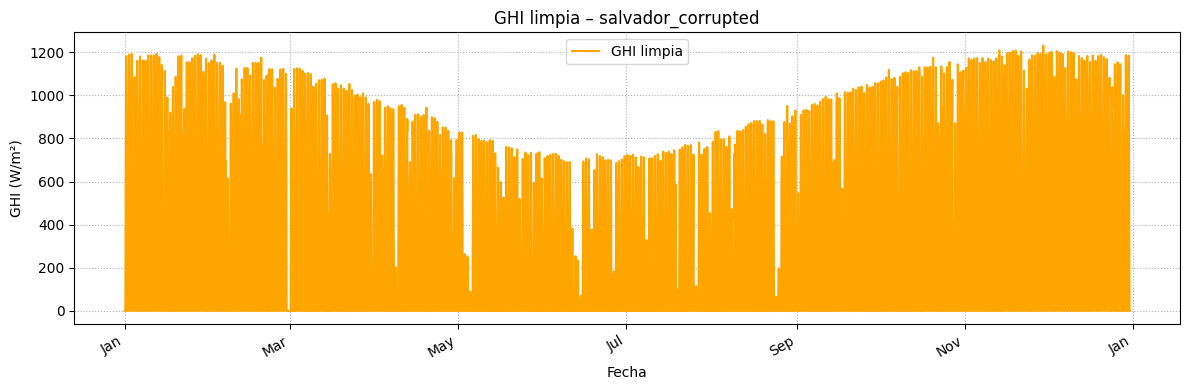

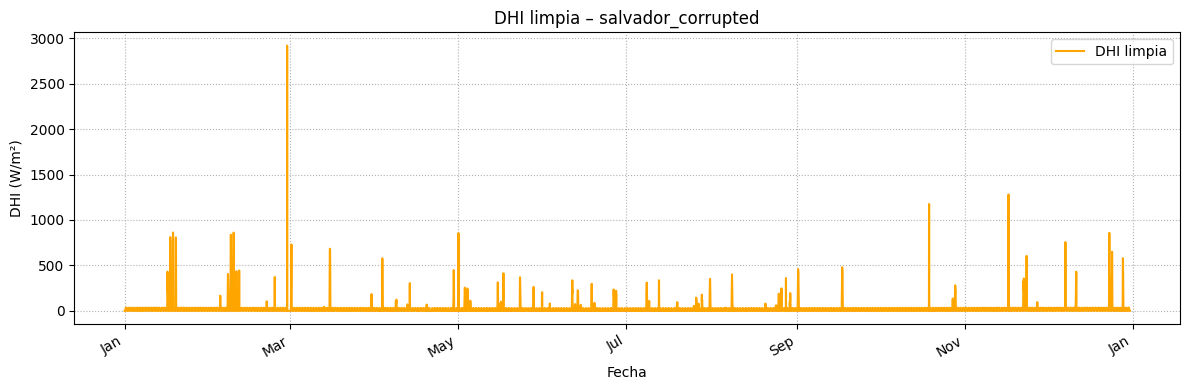

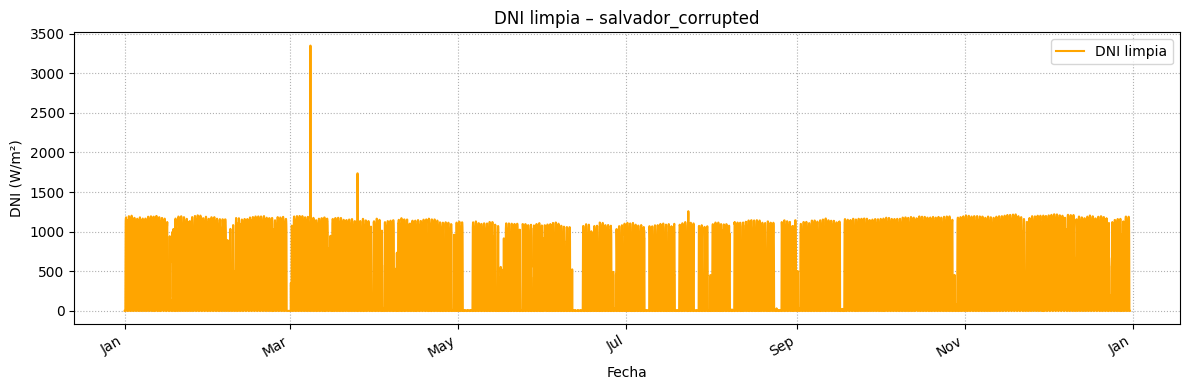

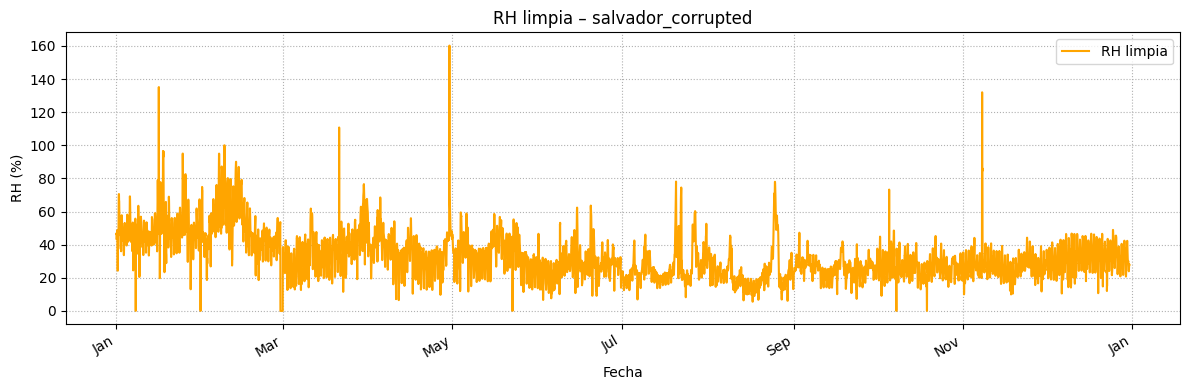

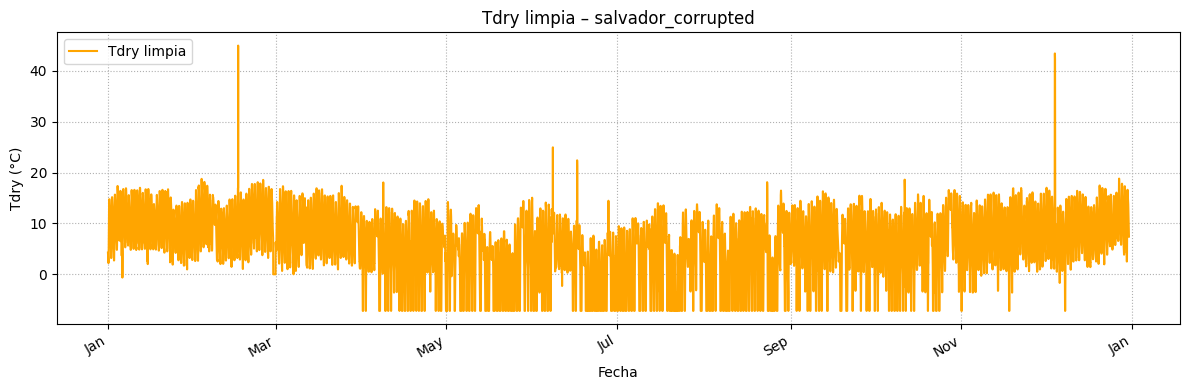


📈 Series limpias para Vallenar_corrupted


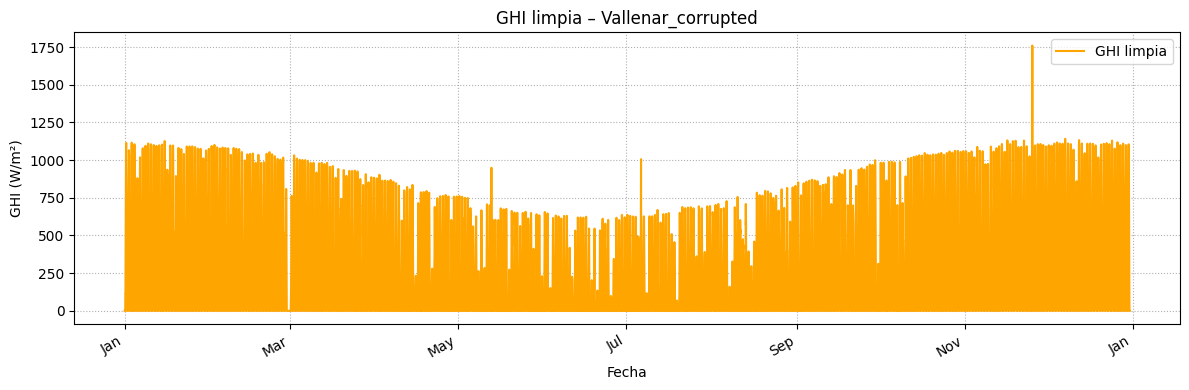

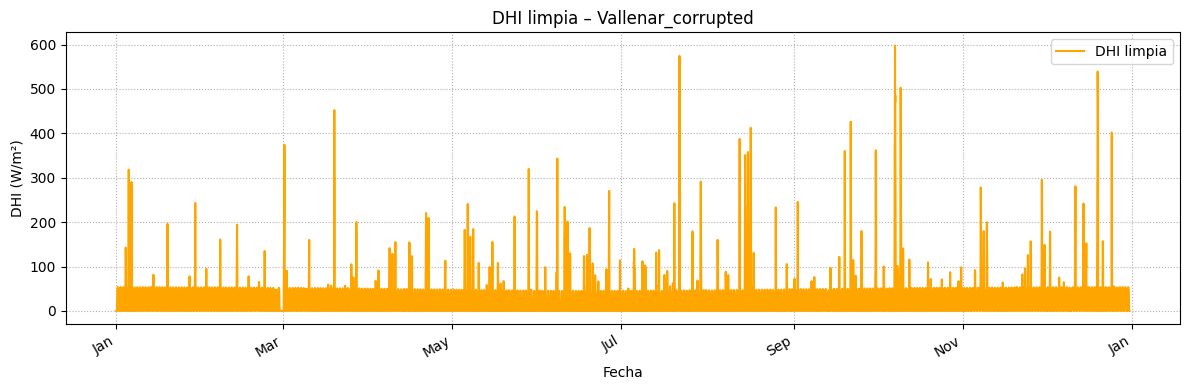

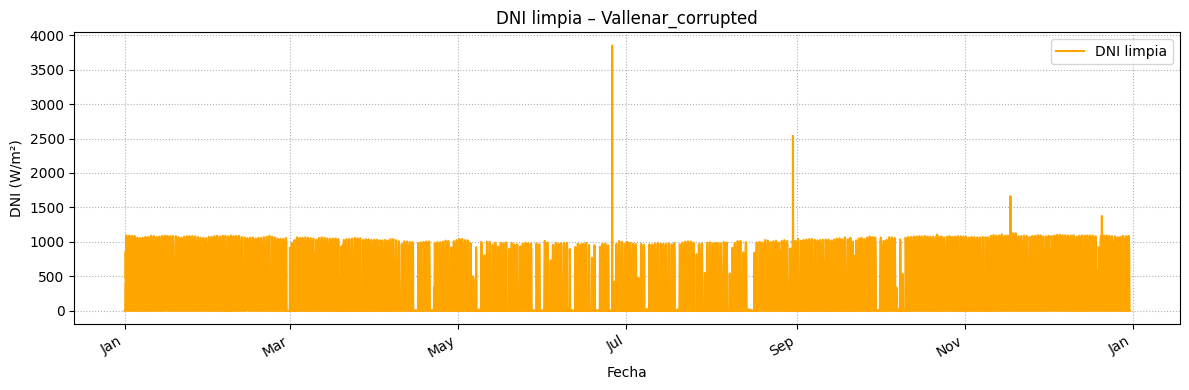

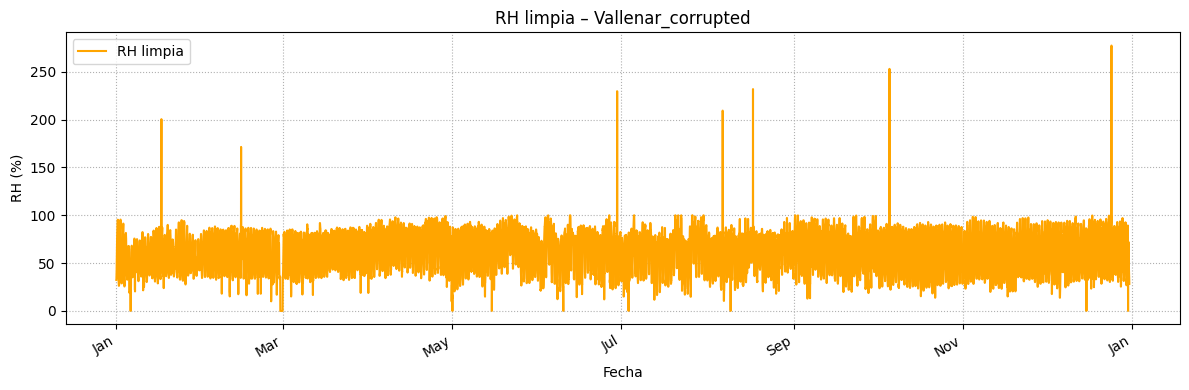

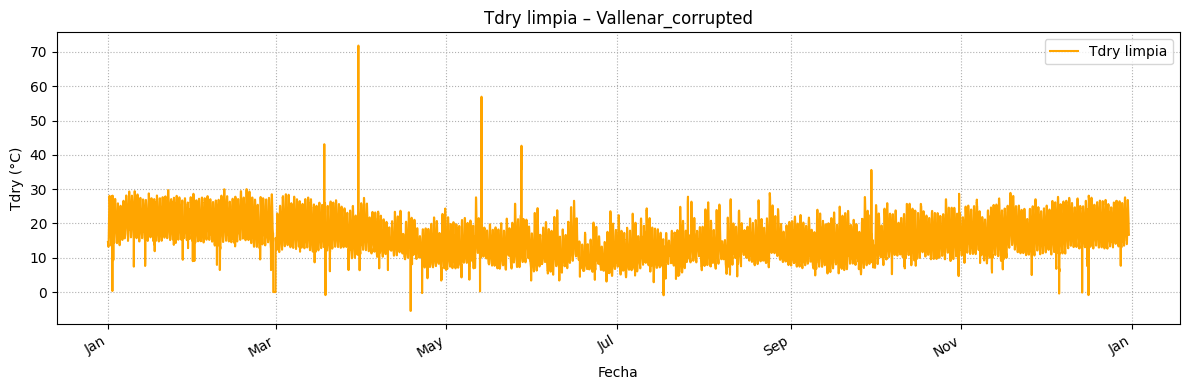


📈 Series limpias para calama_corrupted


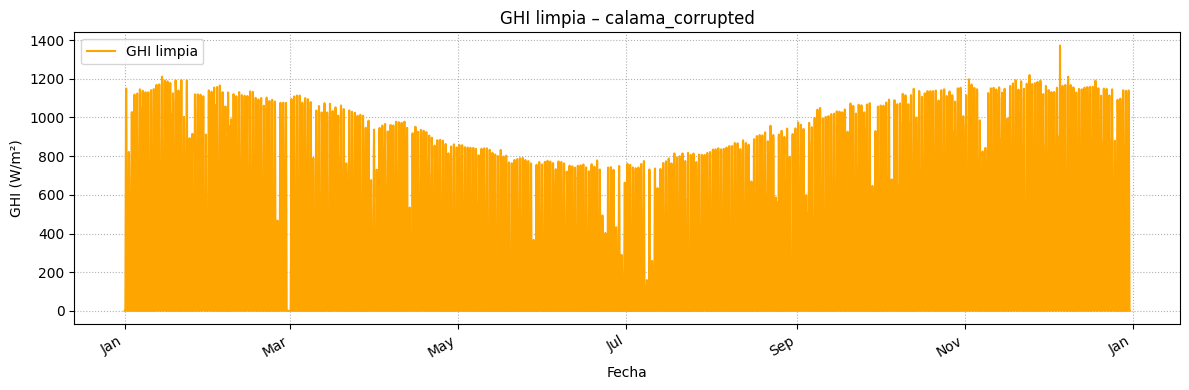

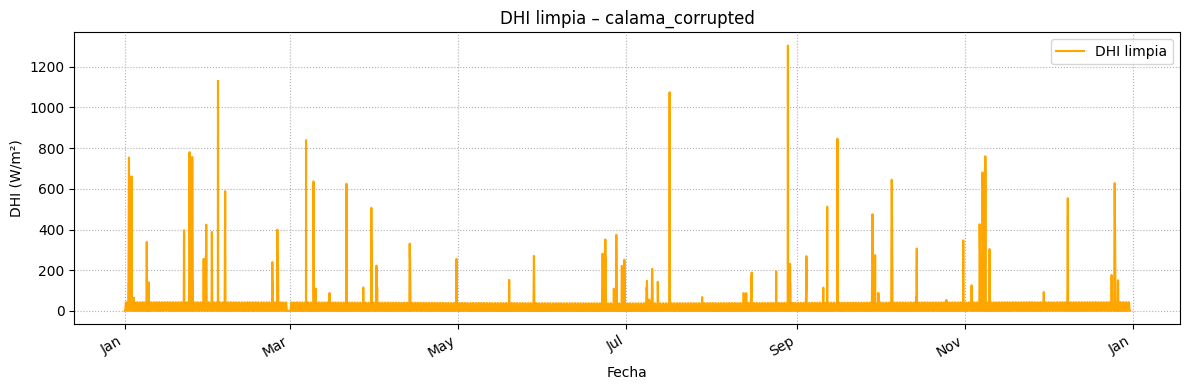

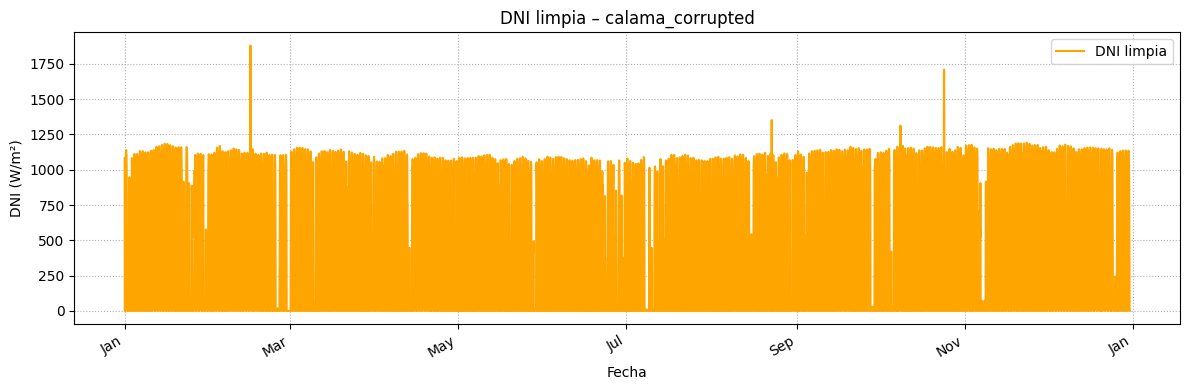

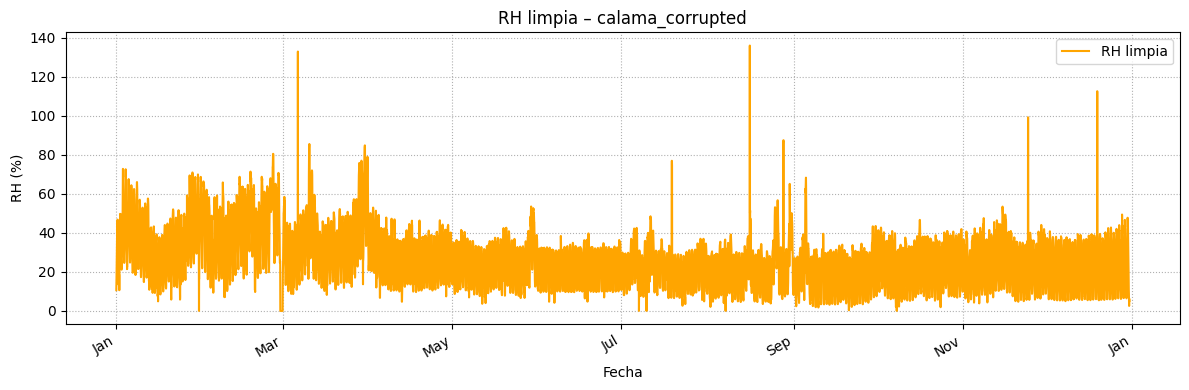

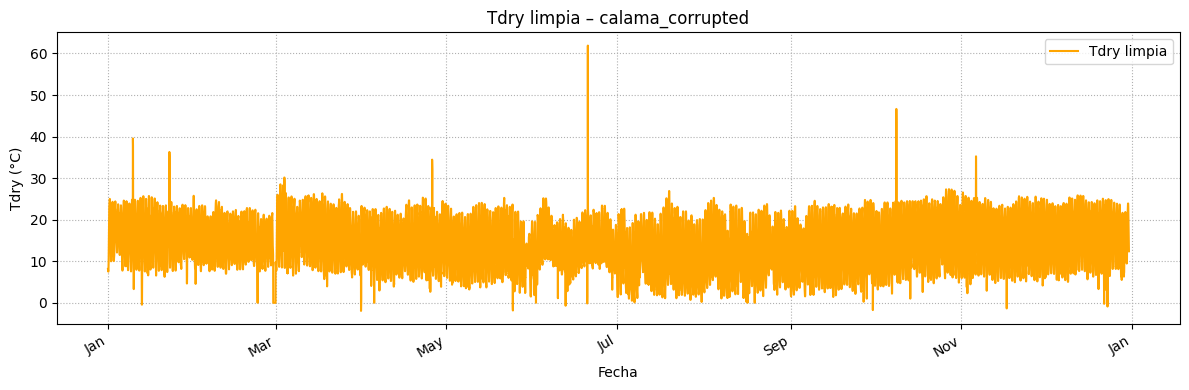

✅ Guardado: /home/miguelo/molivares/PRUEBA 2/salvador_corrupted_filtrado.csv
✅ Guardado: /home/miguelo/molivares/PRUEBA 2/Vallenar_corrupted_filtrado.csv
✅ Guardado: /home/miguelo/molivares/PRUEBA 2/calama_corrupted_filtrado.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# ------------------------------------------------------------------
# 0) Definir carpeta y archivos
# ------------------------------------------------------------------
base_path = "/home/miguelo/molivares/PRUEBA 2"
file_names = [
    "salvador_corrupted.csv",
    "Vallenar_corrupted.csv",
    "calama_corrupted.csv"
]

# ------------------------------------------------------------------
# 1) Función para cargar y limpiar CSV con detección de TMY
# ------------------------------------------------------------------
def cargar_y_limpiar_csv(filepath, country):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()

    # Detectar si es un TMY (8760 filas) y crear Timestamp
    if all(col in df.columns for col in ['Year','Month','Day','Hour','Minute']):
        if len(df) == 8760:
            print(f"📅 Detectado TMY en {country}, usando año 2020 para Timestamp")
            df['Timestamp'] = pd.to_datetime({
                'year': 2020,
                'month': df['Month'],
                'day': df['Day'],
                'hour': df['Hour'],
                'minute': df['Minute']
            }, errors='coerce')
        else:
            df['Timestamp'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])
    else:
        raise ValueError(f"❌ No se encontraron columnas de fecha adecuadas en {filepath}")

    # Limpiar strings vacíos o 'NA'
    for col in df.columns:
        if df[col].dtype == object and col != 'Timestamp':
            df[col] = (df[col].astype(str)
                           .str.strip()
                           .replace({'': np.nan,'NA': np.nan,'NaN': np.nan}))

    # Convertir todo menos Timestamp a numérico
    for col in df.columns:
        if col != 'Timestamp':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Reemplazar negativos por 0 en variables donde no tiene sentido negativo
    cols_neg = ['GHI','DHI','DNI','RH','Pres','Wspd']  # Tdry puede ser negativo
    for col in cols_neg:
        if col in df.columns:
            df[col] = df[col].mask(df[col] < 0, 0)

    df = df.fillna(0)

    print(f"\n📊 Resumen estadístico para {country}:\n")
    print(df.select_dtypes(include=[np.number]).describe())

    return df

# ------------------------------------------------------------------
# 2) Limpieza inteligente (envolvente + mediana móvil)
# ------------------------------------------------------------------
def limpiar_columnas_inteligente(df, expected_rows=8760, p_clear=0.975, win_med=4):
    start = df['Timestamp'].min()
    full = (df.set_index('Timestamp')
              .reindex(pd.date_range(start, periods=expected_rows, freq='H'))
              .rename_axis('Timestamp'))
    full.reset_index(inplace=True)

    col_solares = [c for c in ['GHI','DHI','DNI'] if c in df.columns]
    col_otras   = [c for c in df.select_dtypes(include=[np.number]).columns 
                   if c not in col_solares]

    # Filtrado robusto para irradiancias
    for var in col_solares:
        s0 = full[var].mask(full[var] < 0, 0)
        tmp = s0.to_frame(var)
        tmp['Month'] = full['Timestamp'].dt.month
        tmp['Hour']  = full['Timestamp'].dt.hour
        env = (tmp.dropna()
                  .groupby(['Month','Hour'])[var]
                  .quantile(p_clear)
                  .unstack()
                  .fillna(0))
        try:
            months = full['Timestamp'].dt.month.values - 1
            hours  = full['Timestamp'].dt.hour.values
            caps   = env.values[months,hours]
        except:
            caps = s0.values
        s_cap = np.minimum(s0.values, caps)
        s_med = (pd.Series(s_cap, index=full['Timestamp'])
                   .rolling(window=win_med, center=True, min_periods=1)
                   .median())
        full[f'{var}_clean'] = s_med.fillna(0).values

    # Mediana móvil para el resto (permitir Tdry negativo)
    for var in col_otras:
        if var == 'Tdry':
            s0 = full[var]
        else:
            s0 = full[var].mask(full[var] < 0, 0)
        s_med = (pd.Series(s0.values, index=full['Timestamp'])
                   .rolling(window=win_med, center=True, min_periods=1)
                   .median())
        full[f'{var}_clean'] = s_med.fillna(0).values

    return full

# ------------------------------------------------------------------
# 3) Cargar y limpiar cada archivo
# ------------------------------------------------------------------
dataframes = {}
for file in file_names:
    country = os.path.splitext(file)[0]
    path = os.path.join(base_path, file)
    df = cargar_y_limpiar_csv(path, country)
    dataframes[country] = df

# ------------------------------------------------------------------
# 4) Aplicar limpieza inteligente
# ------------------------------------------------------------------
df_proc = {c: limpiar_columnas_inteligente(df) 
           for c, df in dataframes.items()}

# ------------------------------------------------------------------
# 5) Graficar sólo las series limpias de irradiancia, RH y Tdry
#    con unidad de medida en el eje Y
# ------------------------------------------------------------------
vars_to_plot = ['GHI','DHI','DNI','RH','Tdry']
units = {
    'GHI': 'W/m²',
    'DHI': 'W/m²',
    'DNI': 'W/m²',
    'RH': '%',
    'Tdry': '°C'
}

for pais, df in df_proc.items():
    print(f"\n📈 Series limpias para {pais}")
    for var in vars_to_plot:
        clean = df[f'{var}_clean']
        if f'{var}_clean' in df.columns:
            plt.figure(figsize=(12,4))
            plt.plot(df['Timestamp'], clean, lw=1.5, color='orange', label=f'{var} limpia')
            plt.title(f'{var} limpia – {pais}')
            plt.xlabel('Fecha')
            plt.ylabel(f"{var} ({units[var]})")
            plt.grid(True, ls=':')
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            plt.gcf().autofmt_xdate()
            plt.legend()
            plt.tight_layout()
            plt.show()

# ------------------------------------------------------------------
# 6) Guardar CSV final con sólo Timestamp y variables clean
# ------------------------------------------------------------------
for pais, df in df_proc.items():
    cols_clean = [c for c in df.columns if c.endswith('_clean')]
    cols_out   = ['Timestamp'] + cols_clean
    df_out     = df[cols_out].copy()
    df_out.columns = ['Timestamp'] + [c.replace('_clean','') for c in cols_clean]
    out_file = os.path.join(base_path, f"{pais}_filtrado.csv")
    df_out.to_csv(out_file, index=False)
    print(f"✅ Guardado: {out_file}")


In [29]:
import PySAM.Pvwattsv8 as pv
import pandas as pd
import numpy as np
import os

# Archivos CSV filtrados (asegúrate de que existan en el entorno donde correrás esto)
archivos = {
    "Salvador": "/home/miguelo/molivares/PRUEBA 2/salvador_corrupted_filtrado.csv",
    "Calama": "/home/miguelo/molivares/PRUEBA 2/calama_corrupted_filtrado.csv",
    "Vallenar": "/home/miguelo/molivares/PRUEBA 2/Vallenar_corrupted_filtrado.csv"
}

resumen_energia = {}
resumen_detallado = []

# Simulación para cada sitio
for nombre, ruta_archivo in archivos.items():
    print(f"\n🔧 Simulando para: {nombre}")

    # Leer CSV completo
    df = pd.read_csv(ruta_archivo)
    timestamp = pd.to_datetime(df['Timestamp'])

    # Inferir lat/lon de acuerdo al sitio
    coordenadas = {
        "Salvador": (-26.25, -69.0),
        "Calama": (-22.45, -68.93),
        "Vallenar": (-28.57, -70.76)
    }
    latitud, longitud = coordenadas[nombre]

    # Limpiar y limitar valores para cumplir restricciones de PVWatts
    ghi = df['GHI'].clip(lower=0)
    dni = df['DNI'].clip(lower=0, upper=2000)
    dhi = df['DHI'].clip(lower=0, upper=1500)
    dni = np.minimum(dni, ghi)
    dhi = np.minimum(dhi, ghi - dni)
    tdry = df['Tdry'].clip(lower=-50, upper=80)
    wspd = df['Wspd'].clip(lower=0, upper=75)

    # Construir diccionario solar_resource_data
    try:
        resource_data = {
            'lat': latitud,
            'lon': longitud,
            'tz': -4,
            'elev': 1000,
            'year': timestamp.dt.year.tolist(),
            'month': timestamp.dt.month.tolist(),
            'day': timestamp.dt.day.tolist(),
            'hour': (timestamp.dt.hour + 1).tolist(),
            'minute': [0] * len(df),
            'dn': dni.tolist(),
            'df': dhi.tolist(),
            'tdry': tdry.tolist(),
            'wspd': wspd.tolist()
        }
    except Exception as e:
        print(f"❌ Error al construir solar_resource_data para {nombre}: {e}")
        continue

    # Crear modelo PVWatts
    modelo = pv.default("PVWattsNone")
    modelo.SolarResource.assign({"solar_resource_data": resource_data})
    modelo.SystemDesign.system_capacity = 50000
    modelo.SystemDesign.dc_ac_ratio = 1.2
    modelo.SystemDesign.inv_eff = 96.0
    modelo.SystemDesign.module_type = 0
    modelo.SystemDesign.array_type = 0
    modelo.SystemDesign.tilt = 20
    modelo.SystemDesign.azimuth = 0
    modelo.SystemDesign.losses = 14.0

    try:
        modelo.execute()
    except Exception as e:
        print(f"❌ Error al ejecutar simulación para {nombre}: {e}")
        continue

    potencia_ac = modelo.Outputs.ac
    df_resultado = pd.DataFrame({
        "Timestamp": df["Timestamp"],
        "AC_Power_W": potencia_ac,
        "GHI": ghi,
        "DNI": dni,
        "DHI": dhi,
        "Tdry": tdry,
        "Wspd": wspd
    })

    salida = f"/home/miguelo/molivares/PRUEBA 2/{nombre}_ac_power.csv"
    df_resultado.to_csv(salida, index=False)
    print(f"✅ Potencia horaria guardada en: {salida}")

    energia_total_mwh = df_resultado['AC_Power_W'].sum() / 1e6
    resumen_energia[nombre] = energia_total_mwh

    resumen_detallado.append({
        "Sitio": nombre,
        "Latitud": latitud,
        "Longitud": longitud,
        "Total_MWh": round(energia_total_mwh, 2)
    })

# Mostrar y guardar resumen
print("\n📊 Resumen de energía generada (MWh):")
for sitio, energia in resumen_energia.items():
    print(f"{sitio}: {energia:.2f} MWh")

pd.DataFrame(resumen_detallado).to_csv("/home/miguelo/molivares/PRUEBA 2/resumen_energia_total.csv", index=False)
print("\n📁 Resumen guardado en: resumen_energia_total.csv")



🔧 Simulando para: Salvador
✅ Potencia horaria guardada en: /home/miguelo/molivares/PRUEBA 2/Salvador_ac_power.csv

🔧 Simulando para: Calama
✅ Potencia horaria guardada en: /home/miguelo/molivares/PRUEBA 2/Calama_ac_power.csv

🔧 Simulando para: Vallenar
✅ Potencia horaria guardada en: /home/miguelo/molivares/PRUEBA 2/Vallenar_ac_power.csv

📊 Resumen de energía generada (MWh):
Salvador: 76545.82 MWh
Calama: 76313.29 MWh
Vallenar: 63220.45 MWh

📁 Resumen guardado en: resumen_energia_total.csv



🔧 Sensibilidad LCOE para: Salvador
Base: 0.7838 USD/kWh
FCR: 0.9406 USD/kWh
CapEx: 0.6793 USD/kWh
Precio spot: 0.7055 USD/kWh
Vida útil inversor: 0.8251 USD/kWh
Pérdidas: 0.7685 USD/kWh


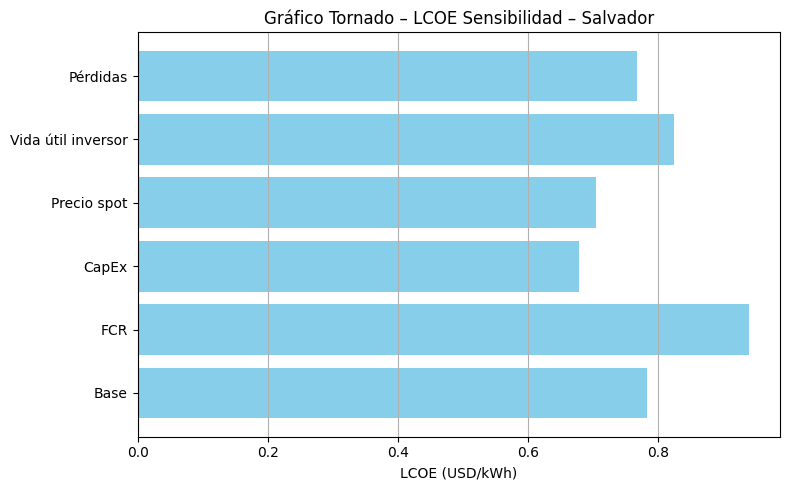


🔧 Sensibilidad LCOE para: Calama
Base: 0.7862 USD/kWh
FCR: 0.9435 USD/kWh
CapEx: 0.6814 USD/kWh
Precio spot: 0.7076 USD/kWh
Vida útil inversor: 0.8276 USD/kWh
Pérdidas: 0.7708 USD/kWh


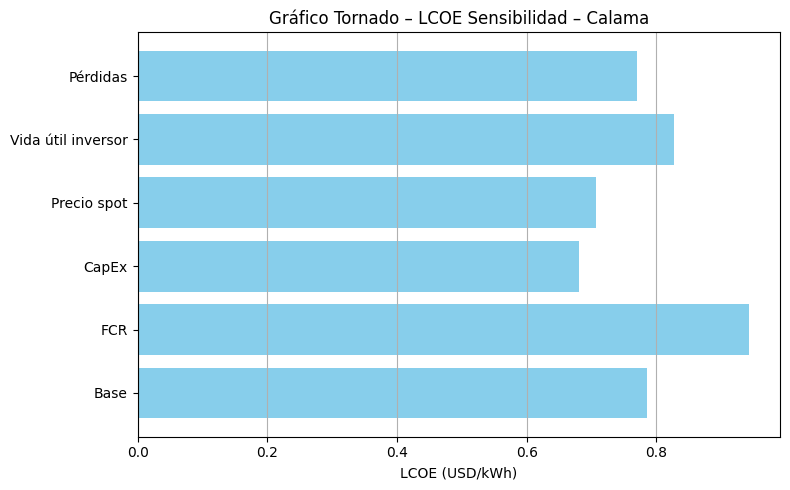


🔧 Sensibilidad LCOE para: Vallenar
Base: 0.9491 USD/kWh
FCR: 1.1389 USD/kWh
CapEx: 0.8225 USD/kWh
Precio spot: 0.8542 USD/kWh
Vida útil inversor: 0.9990 USD/kWh
Pérdidas: 0.9305 USD/kWh


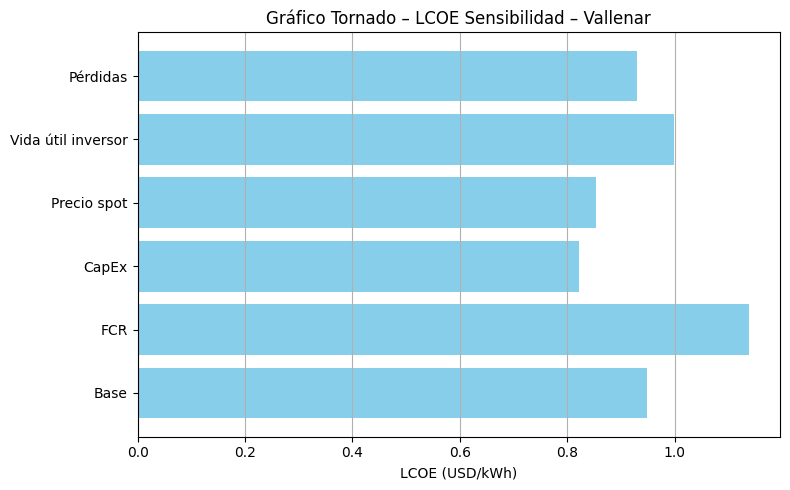

In [40]:
# Cálculo de LCOE con sensibilidad múltiple para cada sitio usando Lcoefcr y energía simulada con PVWatts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PySAM.Pvwattsv8 as pv
import PySAM.Lcoefcr as Lcoefcr
import os

archivos = {
    "Salvador": "/home/miguelo/molivares/PRUEBA 2/salvador_corrupted_filtrado.csv",
    "Calama": "/home/miguelo/molivares/PRUEBA 2/calama_corrupted_filtrado.csv",
    "Vallenar": "/home/miguelo/molivares/PRUEBA 2/Vallenar_corrupted_filtrado.csv"
}

coordenadas = {
    "Salvador": (-26.25, -69.0),
    "Calama": (-22.45, -68.93),
    "Vallenar": (-28.57, -70.76)
}

for nombre, ruta_archivo in archivos.items():
    print(f"\n🔧 Sensibilidad LCOE para: {nombre}")

    df = pd.read_csv(ruta_archivo)
    timestamp = pd.to_datetime(df['Timestamp'])

    ghi = df['GHI'].clip(lower=0)
    dni = df['DNI'].clip(lower=0, upper=2000)
    dhi = df['DHI'].clip(lower=0, upper=1500)
    dni = np.minimum(dni, ghi)
    dhi = np.minimum(dhi, ghi - dni)
    tdry = df['Tdry'].clip(lower=-50, upper=80)
    wspd = df['Wspd'].clip(lower=0, upper=75)

    lat, lon = coordenadas[nombre]

    resource_data = {
        'lat': lat,
        'lon': lon,
        'tz': -4,
        'elev': 1000,
        'year': timestamp.dt.year.tolist(),
        'month': timestamp.dt.month.tolist(),
        'day': timestamp.dt.day.tolist(),
        'hour': (timestamp.dt.hour + 1).tolist(),
        'minute': [0] * len(df),
        'dn': dni.tolist(),
        'df': dhi.tolist(),
        'tdry': tdry.tolist(),
        'wspd': wspd.tolist()
    }

    modelo = pv.default("PVWattsNone")
    modelo.SolarResource.assign({"solar_resource_data": resource_data})
    modelo.SystemDesign.system_capacity = 50000
    modelo.SystemDesign.dc_ac_ratio = 1.2
    modelo.SystemDesign.inv_eff = 96
    modelo.SystemDesign.module_type = 0
    modelo.SystemDesign.array_type = 0
    modelo.SystemDesign.tilt = 20
    modelo.SystemDesign.azimuth = 0
    modelo.SystemDesign.losses = 14.0
    modelo.execute()
    annual_energy = modelo.Outputs.annual_energy

    base_params = {
        'annual_energy': annual_energy,
        'capital_cost': 600e6,
        'fixed_charge_rate': 0.08,
        'fixed_operating_cost': 12e6,
        'variable_operating_cost': 0
    }

    escenarios = {
        "FCR": {**base_params, 'fixed_charge_rate': 0.10},
        "CapEx": {**base_params, 'capital_cost': 500e6},
        "Precio spot": {**base_params, 'fixed_operating_cost': 6e6},
        "Vida útil inversor": {**base_params, 'annual_energy': annual_energy * 0.95},
        "Pérdidas": {**base_params, 'annual_energy': annual_energy * 1.02}
    }

    escenarios = {"Base": base_params, **escenarios}

    lcoe_resultados = []

    for etiqueta, params in escenarios.items():
        model = Lcoefcr.new()
        for k, v in params.items():
            setattr(model.SimpleLCOE, k, v)
        model.execute()
        lcoe_resultados.append(model.Outputs.lcoe_fcr)
        print(f"{etiqueta}: {model.Outputs.lcoe_fcr:.4f} USD/kWh")

    # Tornado plot
    fig, ax = plt.subplots(figsize=(8, 5))
    y = np.arange(len(escenarios))
    ax.barh(y, lcoe_resultados, color='skyblue')
    ax.set_yticks(y)
    ax.set_yticklabels(list(escenarios.keys()))
    ax.set_xlabel("LCOE (USD/kWh)")
    ax.set_title(f"Gráfico Tornado – LCOE Sensibilidad – {nombre}")
    ax.grid(True, axis='x')
    plt.tight_layout()
    plt.show()


In [30]:
# Dashboard interactivo con selectores de año, mes y día separados y funcionales

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Archivos disponibles
dic_archivos = {
    "Salvador": "/home/miguelo/molivares/PRUEBA 2/Salvador_ac_power.csv",
    "Calama": "/home/miguelo/molivares/PRUEBA 2/Calama_ac_power.csv",
    "Vallenar": "/home/miguelo/molivares/PRUEBA 2/Vallenar_ac_power.csv"
}

# Widgets de selección
sitio_selector = widgets.Dropdown(options=list(dic_archivos.keys()),
                                  value="Salvador", description="Sitio:")
año_selector = widgets.Dropdown(description="Año:")
mes_selector = widgets.Dropdown(description="Mes:")
dia_selector = widgets.Dropdown(description="Día:")
output = widgets.Output()

# Funciones de actualización

def cargar_df():
    df = pd.read_csv(dic_archivos[sitio_selector.value])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Año'] = df['Timestamp'].dt.year.astype(int)
    df['Mes'] = df['Timestamp'].dt.month.astype(int)
    df['Día'] = df['Timestamp'].dt.day.astype(int)
    return df

def actualizar_anio(change):
    df = cargar_df()
    años = sorted(df['Año'].unique())
    año_selector.options = años
    año_selector.value = años[0]
    actualizar_mes(None)

def actualizar_mes(change):
    df = cargar_df()
    año = año_selector.value
    meses = sorted(df[df['Año'] == año]['Mes'].unique())
    mes_selector.options = meses
    mes_selector.value = meses[0]
    actualizar_dia(None)

def actualizar_dia(change):
    df = cargar_df()
    año = año_selector.value
    mes = mes_selector.value
    dias = sorted(df[(df['Año'] == año) & (df['Mes'] == mes)]['Día'].unique())
    dia_selector.options = dias
    dia_selector.value = dias[0]
    mostrar_dia(None)

# Mostrar día y KPIs
def mostrar_dia(change):
    with output:
        clear_output(wait=True)
        df = cargar_df()
        año = año_selector.value
        mes = mes_selector.value
        dia = dia_selector.value
        mask = ((df['Año'] == año) & (df['Mes'] == mes) & (df['Día'] == dia))
        dfa = df.loc[mask]
        if dfa.empty:
            print(f"No hay datos para {año}-{mes:02d}-{dia:02d}")
            return
        # KPIs
        energia_kwh = dfa['AC_Power_W'].sum() / 1000
        cf = energia_kwh / (50 * 1000 * 24)
        lcoe = 600e6 / (energia_kwh * 20) if energia_kwh > 0 else 0
        print(f"\n🔎 KPIs para {sitio_selector.value} – {año}-{mes:02d}-{dia:02d}")
        print(f"E_kWh: {energia_kwh:.2f} | CF: {cf:.2f} | LCOE: {lcoe:.2f} USD/kWh")
        # Curva diaria
        curva = dfa.groupby(dfa['Timestamp'].dt.hour)['AC_Power_W'].mean()
        plt.figure(figsize=(8, 4))
        plt.plot(curva.index, curva.values / 1000)
        plt.grid(True)
        plt.xlabel("Hora del día")
        plt.ylabel("Potencia AC (kW)")
        plt.title(f"Curva diaria – {sitio_selector.value} ({año}-{mes:02d}-{dia:02d})")
        plt.tight_layout()
        plt.show()

# Conectar observadores
sitio_selector.observe(lambda change: actualizar_anio(None), names='value')
año_selector.observe(actualizar_mes, names='value')
mes_selector.observe(actualizar_dia, names='value')
dia_selector.observe(mostrar_dia, names='value')

# Mostrar interface inicial
display(widgets.HBox([sitio_selector, año_selector, mes_selector, dia_selector]), output)
# Inicializar
actualizar_anio(None)


Output()